# Tutorial 2. Network Generation, part 2

In this tutorial we explore the different types of network orderings that ```network_layout()``` function from the *netgen* module can generate.

### Imports

In [1]:
import geopandas as gpd
import pandas as pd
import netsim.netgen as ng
import netsim.utils as utils

### Read a sample shapefile

In [2]:
fn = r'..\data\sample\sample15.shp'

We use geopandas to read the shapefile that contains the location and the columns needed to run the simulation. In case the location file is a simple a text file, e.g. *comma-delimited* or *csv*, use
```python
import pandas as pd
df = pd.read_csv(filename)
```
instead.


In [3]:
df= gpd.read_file(fn)
df

,seq,group,easting,northing,id,geometry
0,1,1,530564.106893,4.389298e+06,0,POINT (530564.1068926951 4389297.70034213)
1,1,2,530958.928321,4.389355e+06,1,POINT (530958.9283212668 4389354.664627844)
2,2,2,530892.142607,4.389274e+06,2,POINT (530892.142606981 4389274.128913558)
3,3,2,531198.571178,4.389410e+06,3,POINT (531198.5711784097 4389409.664627844)
4,1,3,531041.428321,4.389339e+06,4,POINT (531041.4283212668 4389338.95034213)
5,1,3,531031.606893,4.388891e+06,5,POINT (531031.6068926954 4388891.093199273)
6,1,3,531082.678321,4.388915e+06,6,POINT (531082.6783212668 4388914.664627844)
7,1,3,530373.571178,4.388598e+06,7,POINT (530373.5711784093 4388598.414627844)
8,1,4,530416.785464,4.388740e+06,8,POINT (530416.7854641236 4388739.843199273)
9,1,4,530491.428321,4.388703e+06,9,POINT (530491.4283212665 4388702.521770701)


We shall used a smaller version of these locations.

In [4]:
df = df.drop(df.index[8:15])
df

,seq,group,easting,northing,id,geometry
0,1,1,530564.106893,4.389298e+06,0,POINT (530564.1068926951 4389297.70034213)
1,1,2,530958.928321,4.389355e+06,1,POINT (530958.9283212668 4389354.664627844)
2,2,2,530892.142607,4.389274e+06,2,POINT (530892.142606981 4389274.128913558)
3,3,2,531198.571178,4.389410e+06,3,POINT (531198.5711784097 4389409.664627844)
4,1,3,531041.428321,4.389339e+06,4,POINT (531041.4283212668 4389338.95034213)
5,1,3,531031.606893,4.388891e+06,5,POINT (531031.6068926954 4388891.093199273)
6,1,3,531082.678321,4.388915e+06,6,POINT (531082.6783212668 4388914.664627844)
7,1,3,530373.571178,4.388598e+06,7,POINT (530373.5711784093 4388598.414627844)


We run the ```setup()``` function in the *netgen* module to check whether the table with the information needed to run the simulation has all the appropriate columns and values within these. 

In [5]:
df = ng.setup(df)


 No corrections or errors !! 


### Creating a network generator

The next step we run the ```create_network_generator()``` function to create a *network generator* that we can  use to produce different versions, or iterations, of our network.

In [6]:
netgentor, net_info, total_iterations = ng.create_network_generator(df)


 iteration broken per group....

   group  num_loc  num_iter    iter_type
0      1        1         1       single
1      2        3         1       single
2      3        4        24  permutation

 total number of iterations.... 24


### Creating a network of paths

 The ```network_layout()``` function transforms an iteration generated by the generator created using the  ```create_network_generator()``` function into a network of paths. This function can generate several different types of networks. Let's explore this using a single iteration,

In [7]:
sample_iteration = list(next(netgentor))
sample_iteration

[(0,), (1, 2, 3), (4, 5, 6, 7)]

#### *close* network
Let's generate a 'close' network of paths, the *default* network type. This type of network is defined as a close circuit of paths amongst the different locations in each group. Each group is independent (no connection) from each other

In [8]:
df_net = ng.network_layout(df, sample_iteration, 1)
df_net

,origin,destination,iteration
0,1,2,1
1,2,3,1
2,3,1,1
3,4,5,1
4,5,6,1
5,6,7,1
6,7,4,1


We can generate a very simple visualization of the network using ```plot_network()``` in the *utils* module 

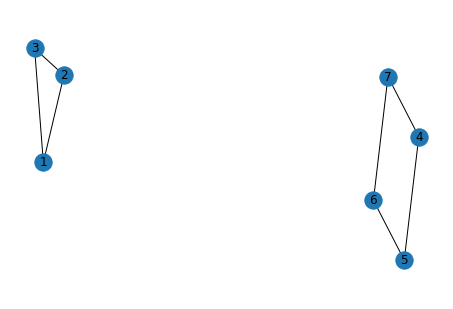

In [9]:
utils.plot_network(df_net)

Note that with the exception of the first group (which is only made of two locations), there is only one path for each pair of locations. If we want, we can change this by including the parameter ```twoway = True``` when calling the function (this parameter can be used with all network options) 

In [10]:
df_net = ng.network_layout(df, sample_iteration, 1, twoway= True)
df_net

,origin,destination,iteration
0,1,2,1
1,2,1,1
2,2,3,1
3,3,2,1
4,3,1,1
5,1,3,1
6,4,5,1
7,5,4,1
8,5,6,1
9,6,5,1


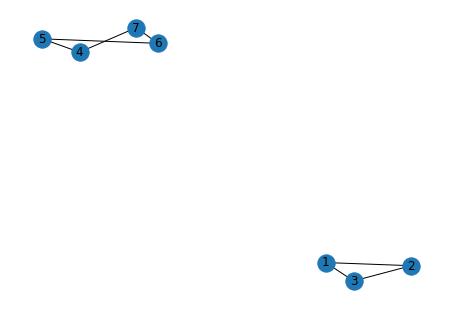

In [11]:
utils.plot_network(df_net)

*N.B.* If you plot this new version with ´´´plot_network()´´´ you will not observe any qualitative difference (it might look different because networks are rendered slightly differently each time)  as 'return' paths are drawn on top of original ones.

With the *opt* parameter  ```network_layout()``` can define other types of network. Currently *opt* can take the following values ```['close', 'central', 'decentral', 'distributed', 'all]```

#### *central*ized network

In [12]:
df_net = ng.network_layout(df, sample_iteration, 1, opt='central')
df_net

,origin,destination,iteration
0,1,0,1
1,2,0,1
2,3,0,1
3,4,0,1
4,5,0,1
5,6,0,1
6,7,0,1


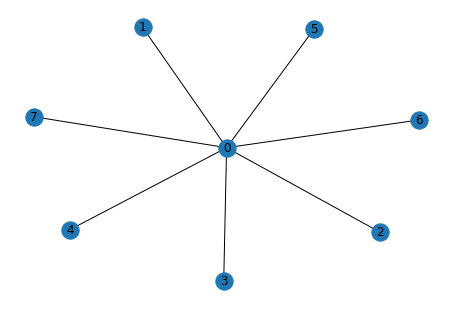

In [13]:
utils.plot_network(df_net)

This option defines a network of paths that consists of a centralized set of paths from the locations of the first group to all of the locations in the remaining groups. Paths amongst the locations in the first group are generated first and then paths from the remaining locations (regardless of whether they are in different groups) to each of the first group locations are generated.

#### *decentral*ized network

In [14]:
df_net = ng.network_layout(df, sample_iteration, 1, opt='decentral')
df_net

,origin,destination,iteration
0,1,0,1
1,2,0,1
2,3,0,1
3,4,1,1
4,4,2,1
5,4,3,1
6,5,1,1
7,5,2,1
8,5,3,1
9,6,1,1


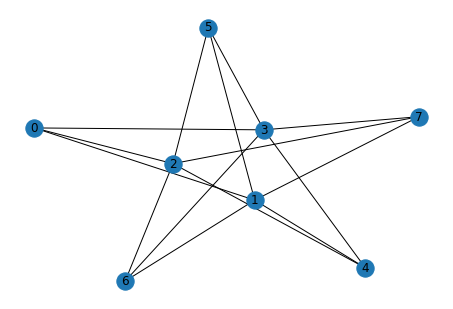

In [15]:
utils.plot_network(df_net)

This option defines a network of paths so that the locations of each group are connected to the locations of the following (lower level) group.

#### *distributed* network

In [16]:
df_net = ng.network_layout(df, sample_iteration, 1, opt='distributed')
df_net

,origin,destination,iteration
0,1,0,1
1,2,0,1
2,3,0,1
3,1,2,1
4,1,3,1
5,2,3,1
6,4,1,1
7,4,2,1
8,4,3,1
9,5,1,1


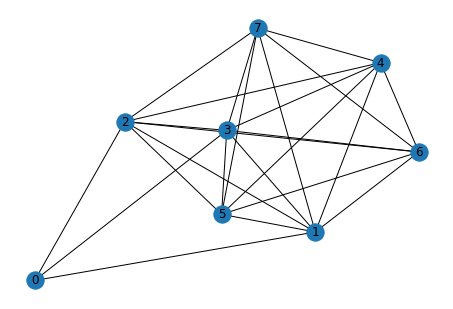

In [17]:
utils.plot_network(df_net)

This option defines a network of paths similar to *decentral*, where the locations of each group are connected to the locations of the following (lower level) group. However, in addition, locations within each group are connected amongst themselves.

#### *all* network

In [18]:
df_net = ng.network_layout(df, sample_iteration, 1, opt='all')
df_net

,origin,destination,iteration
0,0,1,1
1,0,2,1
2,0,3,1
3,0,4,1
4,0,5,1
5,0,6,1
6,0,7,1
7,1,2,1
8,1,3,1
9,1,4,1


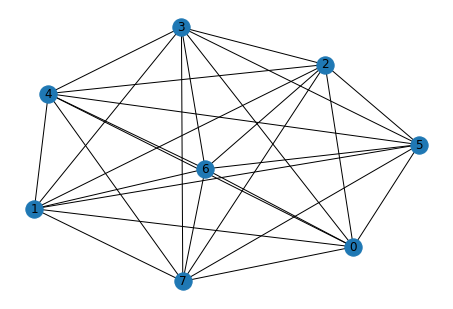

In [19]:
utils.plot_network(df_net)

This option defines a network of paths from all to all locations regardless of whether they are from different groups.

Finally, it is possible to define a network for more than one iteration. In order to do this, however, we need to provide ```network_layout()``` function with a blank dataframe. This is shown in the following cell,

In [14]:
# create a blank dataframe
net = {'origin': 'int32', 'destination': 'int32', 'iteration': 'int32'}
df_net = pd.DataFrame(columns=list(net.keys())).astype(net)

for i in range(3):
    iteration = list(next(netgentor))
    print(iteration)
    df_net = ng.network_layout(df, iteration, i, df_net= df_net, opt='close')
df_net

[(0, 1), (2, 3, 5, 4)]
[(0, 1), (2, 4, 3, 5)]
[(0, 1), (2, 4, 5, 3)]


,origin,destination,iteration
0,0,1,0
1,1,0,0
2,2,3,0
3,3,5,0
4,5,4,0
5,4,2,0
6,0,1,1
7,1,0,1
8,2,4,1
9,4,3,1
